In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction/Car_Price_Prediction.csv


In [47]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [48]:
df = pd.read_csv('/kaggle/input/car-price-prediction/Car_Price_Prediction.csv')

cols = ['Make','Model','Fuel Type','Transmission']

encoders = {}

for col in cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    
x = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, Y_train, Y_test = train_test_split(x,y,train_size=0.8,shuffle=True)

input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train = input_scaler.fit_transform(X_train)
X_test = input_scaler.transform(X_test)

Y_train = output_scaler.fit_transform(np.array(Y_train).reshape(-1,1))
Y_test = output_scaler.transform(np.array(Y_test).reshape(-1,1))

In [49]:
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)

test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))
test_loader = DataLoader(test_set, batch_size = 32, shuffle = True)

In [147]:
#model defination
class ann(nn.Module):

    def __init__(self,input_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim,64)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.fc2 = nn.Linear(64,128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128,256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.d1 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256,512)
        self.bn4 = nn.BatchNorm1d(512)
        
        self.d2 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(512,1)

    def forward(self,X):
        out = F.relu(self.bn1(self.fc1(X)))

        out = F.relu(self.bn2(self.fc2(out)))
        

        out = F.relu(self.bn3(self.fc3(out)))

        out = self.d1(out)
        out = F.relu(self.bn4(self.fc4(out)))

        out = self.d2(out)

        return self.fc5(out)

model = ann(x.shape[1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 100
learning_rate = 0.00001
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1)

For Epoch 500: Loss = 0.16250455871224403
For Epoch 1000: Loss = 0.11005185052752495
For Epoch 1500: Loss = 0.08876328125596046
For Epoch 2000: Loss = 0.08092104315757752
For Epoch 2500: Loss = 0.0918916118144989
For Epoch 3000: Loss = 0.10341063492000103


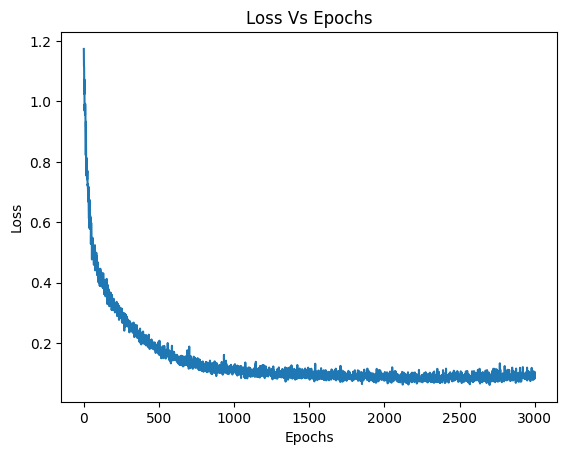

In [148]:
graph = {}

for epoch in range(n_epochs):

    total_loss = 0 
    
    for batch_x, batch_y in train_loader:
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        y_hat = model(batch_x)
    
        l = loss(y_hat, batch_y)
    
        l.backward()
    
        optimizer.step()
    
        optimizer.zero_grad()

        total_loss += l.item() * batch_x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    if (epoch+1) % 10 == 0:
        print(f'For Epoch {epoch+1}: Loss = {avg_loss}')

    graph[epoch+1] = avg_loss

plt.title('Loss Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(graph.keys(),graph.values())

In [150]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_hat = []
y_true = []

model.eval()

for batch_x, batch_y in test_loader:
   
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    
    with torch.no_grad():

        output = model(batch_x)

        y_hat.append(output.cpu())
        y_true.append(batch_y.cpu())

y_hat = torch.cat(y_hat)
y_true = torch.cat(y_true)

y_hat = output_scaler.inverse_transform(y_hat)
y_true = output_scaler.inverse_transform(y_true)

rmse = mean_squared_error(y_true,y_hat) ** 0.5
mae = mean_absolute_error(y_true, y_hat)
r2 = r2_score(y_true, y_hat)

print(f'RMSE = {rmse}, MAE = {mae}, R2 = {r2}')

RMSE = 2135.4310396133997, MAE = 1734.0356908060137, R2 = 0.811872986406879


In [96]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

sk_model = LinearRegression()
poly = PolynomialFeatures(degree=3)

poly_X = poly.fit_transform(X_train)

sk_model.fit(poly_X,Y_train)

LinearRegression()

In [97]:
poly_X_test = poly.transform(X_test)
y_predict = sk_model.predict(poly_X_test)

y_predict = output_scaler.inverse_transform(y_predict)
y_true = output_scaler.inverse_transform(Y_test)

rmse = mean_squared_error(y_true,y_hat) ** 0.5
mae = mean_absolute_error(y_true, y_hat)
r2 = r2_score(y_true, y_hat)

print(f'RMSE = {rmse}, MAE = {mae}, R2 = {r2}')

0.8278792167687486


In [89]:
sk_linear_model = LinearRegression()

sk_linear_model.fit(X_train,Y_train)

LinearRegression()

In [91]:
y_predict = sk_linear_model.predict(X_test)

y_predict = output_scaler.inverse_transform(y_predict)
y_true = output_scaler.inverse_transform(Y_test)

rmse = mean_squared_error(y_true,y_hat) ** 0.5
mae = mean_absolute_error(y_true, y_hat)
r2 = r2_score(y_true, y_hat)

print(f'RMSE = {rmse}, MAE = {mae}, R2 = {r2}')

1541.457452845509
